In [6]:
import torch
from tqdm import tqdm
from CB2CFMultiModalEncoder import CB2CFMultiModalEncoder
import matplotlib.pyplot as plt


In [7]:
from enum import Enum


class MODE(Enum):
    BPR1 = 1
    BPR2 = 2

SELECTED_MODE = MODE.BPR2

dataset_name = "cb2cf_train_dataset_with_bpr1.pt" if SELECTED_MODE == MODE.BPR1 else "cb2cf_train_dataset.pt"
model_file_name = "cb2cf_multi_modal_encoder_model_with_bpr1.pt" if SELECTED_MODE == MODE.BPR1 else "cb2cf_multi_modal_encoder_model.pt"

In [8]:
# load cb2cf_train_dataset with torch
training_data = torch.load(dataset_name)

train_size = int(0.9 * len(training_data))
val_size = len(training_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(training_data, [train_size, val_size])


In [9]:
# Create CB2CFTransformer model
number_of_genres = train_dataset[0]["genres"].shape[0]
number_of_actors = train_dataset[0]["actors"].shape[0]
number_of_directors = train_dataset[0]["directors"].shape[0]
number_of_languages = train_dataset[0]["language"].shape[0]
item_embedding_dim = train_dataset[0]["embeddings"].shape[0]


model = CB2CFMultiModalEncoder(
    number_of_genres=number_of_genres,
    number_of_actors=number_of_actors,
    number_of_directors=number_of_directors,
    number_of_languages=number_of_languages,
    item_embedding_dim=item_embedding_dim,
    dropout=0.25,
)


In [10]:
criterion = torch.nn.MSELoss()
learning_rate =  1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)


Using device: cuda:0


In [11]:
# Create train and validation dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train the model
num_epochs = 15
train_loss_history = []
val_loss_history = []
should_early_stop = False
best_val_loss = float("inf")

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        output = model(
            genres=batch["genres"].to(device),
            actors=batch["actors"].to(device),
            directors=batch["directors"].to(device),
            unix_release_time=batch["unix_release_time"].to(device),
            description=batch["description"],
            language=batch["language"].to(device),
        )
        loss = criterion(output, batch["embeddings"].to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            # genres, actors, directors, unix_release_time, description, language
            output = model(
                genres=batch["genres"].to(device),
                actors=batch["actors"].to(device),
                directors=batch["directors"].to(device),
                unix_release_time=batch["unix_release_time"].to(device),
                description=batch["description"],
                language=batch["language"].to(device),
            )
            loss = criterion(output, batch["embeddings"].to(device))
            val_loss += loss.item()
    val_loss /= len(val_dataloader)
    val_loss_history.append(val_loss)
    if val_loss < best_val_loss:
        torch.save(model, model_file_name)
        best_val_loss = min(best_val_loss, val_loss)
        print(f"Saved model with best validation loss of {best_val_loss:.4f}")

    if len(val_loss_history) > 4:
        if val_loss_history[-1] > val_loss_history[-2] > val_loss_history[-3] > val_loss_history[-4]:
            print("Early stopping")
            should_early_stop = True
            break
    print(f"Epoch {epoch}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")


100%|██████████| 28/28 [00:01<00:00, 26.13it/s]


Saved model with best validation loss of 0.1343
Epoch 0: train loss = 0.2156, val loss = 0.1343


100%|██████████| 28/28 [00:01<00:00, 26.21it/s]


Saved model with best validation loss of 0.1210
Epoch 1: train loss = 0.1533, val loss = 0.1210


100%|██████████| 28/28 [00:01<00:00, 25.97it/s]


Saved model with best validation loss of 0.1171
Epoch 2: train loss = 0.1346, val loss = 0.1171


100%|██████████| 28/28 [00:01<00:00, 26.46it/s]


Saved model with best validation loss of 0.1144
Epoch 3: train loss = 0.1228, val loss = 0.1144


100%|██████████| 28/28 [00:01<00:00, 25.87it/s]


Saved model with best validation loss of 0.1129
Epoch 4: train loss = 0.1169, val loss = 0.1129


100%|██████████| 28/28 [00:01<00:00, 26.16it/s]


Epoch 5: train loss = 0.1091, val loss = 0.1141


100%|██████████| 28/28 [00:01<00:00, 26.16it/s]


Epoch 6: train loss = 0.1050, val loss = 0.1135


100%|██████████| 28/28 [00:01<00:00, 26.08it/s]


Epoch 7: train loss = 0.1036, val loss = 0.1152


100%|██████████| 28/28 [00:01<00:00, 26.05it/s]


Saved model with best validation loss of 0.1124
Epoch 8: train loss = 0.0997, val loss = 0.1124


100%|██████████| 28/28 [00:01<00:00, 26.04it/s]


Epoch 9: train loss = 0.0954, val loss = 0.1150


100%|██████████| 28/28 [00:01<00:00, 25.96it/s]


Saved model with best validation loss of 0.1117
Epoch 10: train loss = 0.0921, val loss = 0.1117


100%|██████████| 28/28 [00:01<00:00, 27.10it/s]


Epoch 11: train loss = 0.0908, val loss = 0.1127


100%|██████████| 28/28 [00:01<00:00, 27.66it/s]


Epoch 12: train loss = 0.0896, val loss = 0.1144


100%|██████████| 28/28 [00:01<00:00, 27.38it/s]


Epoch 13: train loss = 0.0884, val loss = 0.1136


100%|██████████| 28/28 [00:01<00:00, 27.81it/s]

Epoch 14: train loss = 0.0863, val loss = 0.1161


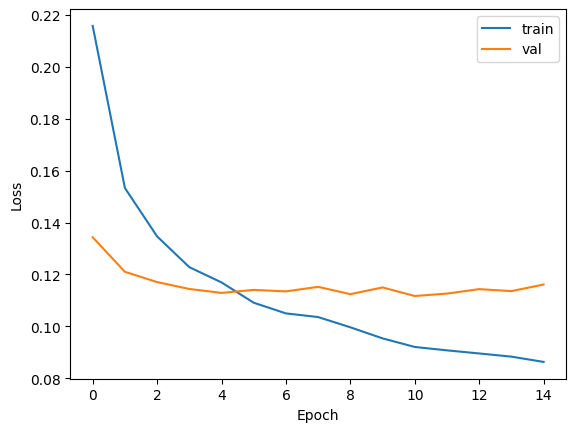

In [12]:
# Plot the loss curves for epochs


plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# torch.save(model.state_dict(), "cb2cf_multi_modal_encoder_model.pt")
